# Model Training, Optimization, and Validation

#### Objectives
- Write your notebook objective here, for example, "Fetch data from Kaggle and save as raw data", or "engineer features for modelling"

#### Inputs
- Write here which data or information you need to run the notebook 

#### Outputs
- Write here which files, code or artefacts you generate by the end of the notebook 

#### Additional Comments
- In case you have any additional comments that don't fit in the previous bullets, please state them here. 


---

## 1. Basic setup

#### Import libraries

In [1]:
import os
import dotenv
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

#from sklearn import ensemble, tree, linear_model
#from sklearn.model_selection import train_test_split, cross_val_score
#from sklearn.metrics import r2_score, mean_squared_error
#from sklearn.utils import shuffle
from bisect import bisect_right
from sklearn.model_selection import train_test_split

#### Load environment variables.

In [2]:
dotenv.load_dotenv()

True

#### File paths

In [3]:
data_dictionary_path = os.path.join(os.getenv("LOCAL_DATASET_PATH"), os.getenv("HOUSING_DATA_DICTIONARY"))
housing_records_path = os.path.join(os.getenv("LOCAL_DATASET_PATH"), os.getenv("HOUSING_RECORDS_FILENAME"))
inherited_houses_path = os.path.join(os.getenv("LOCAL_DATASET_PATH"), os.getenv("INHERITED_HOUSES_FILENAME"))
na_stat_housing_records_path = os.path.join(os.getenv("LOCAL_DATASET_PATH"), os.getenv("NA_STATS_HOUSING_RECORDS_FILENAME"))
correlated_variables_path = os.path.join(os.getenv("LOCAL_DATASET_PATH"), os.getenv("CORRELATED_VARIABLE_FILES"))

#### Other parameters

In [4]:
housing_records_rows = 1460 
housing_records_columns = 24
target_column = "SalePrice"

## 2. Data Loading

#### Housing records

In [5]:
housing_records = pd.read_csv(housing_records_path)
assert housing_records.shape == (housing_records_rows, housing_records_columns)
display(housing_records)

,1stFlrSF,2ndFlrSF,BedroomAbvGr,BsmtExposure,BsmtFinSF1,BsmtFinType1,BsmtUnfSF,EnclosedPorch,GarageArea,GarageFinish,...,LotFrontage,MasVnrArea,OpenPorchSF,OverallCond,OverallQual,TotalBsmtSF,WoodDeckSF,YearBuilt,YearRemodAdd,SalePrice
0,856,854.0,3.0,No,706,GLQ,150,0.0,548,RFn,...,65.0,196.0,61,5,7,856,0.0,2003,2003,208500
1,1262,0.0,3.0,Gd,978,ALQ,284,NaN,460,RFn,...,80.0,0.0,0,8,6,1262,NaN,1976,1976,181500
2,920,866.0,3.0,Mn,486,GLQ,434,0.0,608,RFn,...,68.0,162.0,42,5,7,920,NaN,2001,2002,223500
3,961,NaN,NaN,No,216,ALQ,540,NaN,642,Unf,...,60.0,0.0,35,5,7,756,NaN,1915,1970,140000
4,1145,NaN,4.0,Av,655,GLQ,490,0.0,836,RFn,...,84.0,350.0,84,5,8,1145,NaN,2000,2000,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,953,694.0,3.0,No,0,Unf,953,NaN,460,RFn,...,62.0,0.0,40,5,6,953,0.0,1999,2000,175000
1456,2073,0.0,NaN,No,790,ALQ,589,NaN,500,Unf,...,85.0,119.0,0,6,6,1542,NaN,1978,1988,210000
1457,1188,1152.0,4.0,No,275,GLQ,877,NaN,252,RFn,...,66.0,0.0,60,9,7,1152,NaN,1941,2006,266500
1458,1078,0.0,2.0,Mn,49,NaN,0,112.0,240,Unf,...,68.0,0.0,0,6,5,1078,NaN,1950,1996,142125


In [6]:
na_data = pd.read_csv(na_stat_housing_records_path)
display(na_data)

,Unnamed: 0,count,percentage,should_remove
0,EnclosedPorch,1324,90.68,True
1,WoodDeckSF,1305,89.38,True
2,LotFrontage,259,17.74,True
3,GarageFinish,235,16.10,True
4,BsmtFinType1,145,9.93,False
5,BedroomAbvGr,99,6.78,False
6,2ndFlrSF,86,5.89,False
7,GarageYrBlt,81,5.55,False
8,BsmtExposure,38,2.60,False
9,MasVnrArea,8,0.55,False


### Inherited houses

In [7]:
inherited_houses = pd.read_csv(inherited_houses_path)
assert inherited_houses.shape == (4, 23)
inherited_houses.head()

,1stFlrSF,2ndFlrSF,BedroomAbvGr,BsmtExposure,BsmtFinSF1,BsmtFinType1,BsmtUnfSF,EnclosedPorch,GarageArea,GarageFinish,...,LotArea,LotFrontage,MasVnrArea,OpenPorchSF,OverallCond,OverallQual,TotalBsmtSF,WoodDeckSF,YearBuilt,YearRemodAdd
0,896,0,2,No,468.0,Rec,270.0,0,730.0,Unf,...,11622,80.0,0.0,0,6,5,882.0,140,1961,1961
1,1329,0,3,No,923.0,ALQ,406.0,0,312.0,Unf,...,14267,81.0,108.0,36,6,6,1329.0,393,1958,1958
2,928,701,3,No,791.0,GLQ,137.0,0,482.0,Fin,...,13830,74.0,0.0,34,5,5,928.0,212,1997,1998
3,926,678,3,No,602.0,GLQ,324.0,0,470.0,Fin,...,9978,78.0,20.0,36,6,6,926.0,360,1998,1998


### Correlated variables

In [8]:
correlated_variables = pd.read_csv(correlated_variables_path)
correlated_variables

,featureName,featureCategory
0,KitchenQual,categorical
1,OverallCond,categorical
2,OverallQual,categorical
3,GarageArea,numerical
4,TotalBsmtSF,numerical
5,1stFlrSF,numerical
6,YearBuilt,temporal
7,YearRemodAdd,temporal


In [9]:
categorical_feature_names = correlated_variables[
    correlated_variables["featureCategory"] == "categorical"
]["featureName"].to_list()

print(categorical_feature_names)

['KitchenQual', 'OverallCond', 'OverallQual']


In [10]:
numerical_feature_names = correlated_variables[
    correlated_variables["featureCategory"] == "numerical"
]["featureName"].to_list()

print(numerical_feature_names)

['GarageArea', 'TotalBsmtSF', '1stFlrSF']


In [11]:
temporal_feature_names = correlated_variables[
    correlated_variables["featureCategory"] == "temporal"
]["featureName"].to_list()

print(temporal_feature_names)

['YearBuilt', 'YearRemodAdd']


---

## 3. Feature engineering

### Training Data

#### Target Data

In [12]:
target = housing_records[target_column]
assert target.shape[0] == housing_records_rows
target.describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

##### Calculate basis for aggregate features
We create bins for house sale prices over which we will agreegate numerical and categorical features

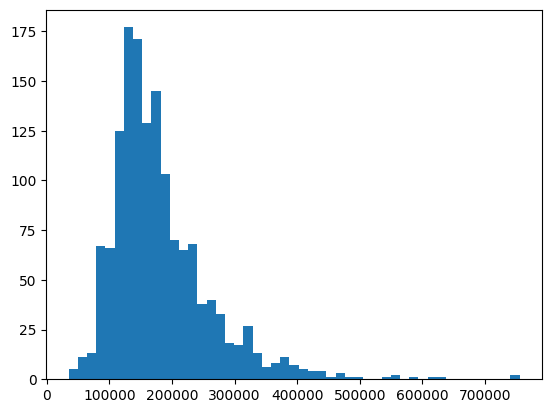

In [13]:
hist = plt.hist(target, bins="auto")
plt.show()

In [14]:
def find_nearest(inp, value_range):
    right = bisect_right(value_range, inp)
    if right == 0:
        bounds = value_range[right]
    elif right == len(value_range):
        bounds = value_range[right - 1]
    elif inp >= value_range[right - 1] and inp <= value_range[right]:
        bounds = value_range[right - 1] 

    return round(bounds)

assert find_nearest(inp=223500, value_range=hist[1]) == 211251

In [15]:
target_column_bin_name = f"{target_column}Bin"
target_bin = pd.DataFrame(
    target.apply(find_nearest, args=(hist[1],))
)
target_bin.columns = [target_column_bin_name]
target_bin.head()

,SalePriceBin
0,196555
1,167163
2,211251
3,137771
4,240643


In [16]:
target_with_bin = pd.DataFrame(pd.concat([target, target_bin], axis=1))
target_with_bin.head()

,SalePrice,SalePriceBin
0,208500,196555
1,181500,167163
2,223500,211251
3,140000,137771
4,250000,240643


#### Categorical features

In [17]:
housing_records_categorical = housing_records[categorical_feature_names]
housing_records_categorical = housing_records_categorical.astype({
    var: "object" for var in categorical_feature_names
})
assert housing_records_categorical.shape == (housing_records_rows, len(categorical_feature_names))
housing_records_categorical.head()

,KitchenQual,OverallCond,OverallQual
0,Gd,5,7
1,TA,8,6
2,Gd,5,7
3,Gd,5,7
4,Gd,5,8


In [18]:
housing_categorical = pd.concat([pd.get_dummies(housing_records_categorical), target_bin], axis=1)\
    .groupby(target_column_bin_name)\
    .agg(["sum", "mean"])
housing_categorical.columns = ["_".join(_) for _ in housing_categorical.columns]
housing_categorical.reset_index()
print(housing_categorical.shape)
housing_categorical.head()

(39, 46)


,KitchenQual_Ex_sum,KitchenQual_Ex_mean,KitchenQual_Fa_sum,KitchenQual_Fa_mean,KitchenQual_Gd_sum,KitchenQual_Gd_mean,KitchenQual_TA_sum,KitchenQual_TA_mean,OverallCond_1_sum,OverallCond_1_mean,...,OverallQual_6_sum,OverallQual_6_mean,OverallQual_7_sum,OverallQual_7_mean,OverallQual_8_sum,OverallQual_8_mean,OverallQual_9_sum,OverallQual_9_mean,OverallQual_10_sum,OverallQual_10_mean
SalePriceBin,,,,,,,,,,,,,,,,,,,,,
34900,0,0.000000,1,0.200000,0,0.000000,4,0.800000,0,0.000000,...,0,0.000000,0,0.000000,0,0.0,0,0.0,0,0.0
49596,0,0.000000,6,0.545455,0,0.000000,5,0.454545,1,0.090909,...,0,0.000000,0,0.000000,0,0.0,0,0.0,0,0.0
64292,0,0.000000,2,0.153846,0,0.000000,11,0.846154,0,0.000000,...,1,0.076923,0,0.000000,0,0.0,0,0.0,0,0.0
78988,2,0.029851,7,0.104478,5,0.074627,53,0.791045,0,0.000000,...,10,0.149254,1,0.014925,0,0.0,0,0.0,0,0.0
93684,0,0.000000,2,0.030303,2,0.030303,62,0.939394,0,0.000000,...,12,0.181818,0,0.000000,0,0.0,0,0.0,0,0.0


In [19]:
target_with_categorical = target_with_bin.merge(
    housing_categorical, 
    left_on=target_column_bin_name, 
    right_index=True,
    how="left"
)
target_with_categorical.head()

,SalePrice,SalePriceBin,KitchenQual_Ex_sum,KitchenQual_Ex_mean,KitchenQual_Fa_sum,KitchenQual_Fa_mean,KitchenQual_Gd_sum,KitchenQual_Gd_mean,KitchenQual_TA_sum,KitchenQual_TA_mean,...,OverallQual_6_sum,OverallQual_6_mean,OverallQual_7_sum,OverallQual_7_mean,OverallQual_8_sum,OverallQual_8_mean,OverallQual_9_sum,OverallQual_9_mean,OverallQual_10_sum,OverallQual_10_mean
0,208500,196555,2,0.028571,1,0.014286,48,0.685714,19,0.271429,...,22,0.314286,38,0.542857,6,0.085714,0,0.0,0,0.0
1,181500,167163,4,0.027586,1,0.006897,69,0.475862,71,0.489655,...,72,0.496552,43,0.296552,7,0.048276,0,0.0,0,0.0
2,223500,211251,1,0.015385,0,0.000000,58,0.892308,6,0.092308,...,12,0.184615,41,0.630769,8,0.123077,0,0.0,0,0.0
3,140000,137771,2,0.011696,3,0.017544,39,0.228070,127,0.742690,...,62,0.362573,16,0.093567,1,0.005848,0,0.0,0,0.0
4,250000,240643,4,0.105263,0,0.000000,29,0.763158,5,0.131579,...,3,0.078947,19,0.500000,16,0.421053,0,0.0,0,0.0


#### Numercial features

In [20]:
housing_records_numerical = housing_records[numerical_feature_names]
housing_records_numerical = housing_records_numerical.astype({
    var: "float" for var in numerical_feature_names
})
assert housing_records_categorical.shape == (housing_records_rows, len(numerical_feature_names))
housing_records_numerical.head()

,GarageArea,TotalBsmtSF,1stFlrSF
0,548.0,856.0,856.0
1,460.0,1262.0,1262.0
2,608.0,920.0,920.0
3,642.0,756.0,961.0
4,836.0,1145.0,1145.0


In [21]:
housing_numerical = pd.concat([housing_records_numerical, target_bin], axis=1)\
    .groupby(target_column_bin_name)\
    .agg(["count", "mean", "max", "min", "sum"])
housing_numerical.columns = ["_".join(_) for _ in housing_numerical.columns]
housing_numerical.reset_index()
print(housing_numerical.shape)
housing_numerical.head()

(39, 15)


,GarageArea_count,GarageArea_mean,GarageArea_max,GarageArea_min,GarageArea_sum,TotalBsmtSF_count,TotalBsmtSF_mean,TotalBsmtSF_max,TotalBsmtSF_min,TotalBsmtSF_sum,1stFlrSF_count,1stFlrSF_mean,1stFlrSF_max,1stFlrSF_min,1stFlrSF_sum
SalePriceBin,,,,,,,,,,,,,,,
34900,5,111.600000,308.0,0.0,558.0,5,489.800000,720.0,0.0,2449.0,5,556.600000,720.0,334.0,2783.0
49596,11,150.909091,504.0,0.0,1660.0,11,594.545455,1276.0,0.0,6540.0,11,798.181818,1276.0,372.0,8780.0
64292,13,242.153846,528.0,0.0,3148.0,13,641.461538,961.0,0.0,8339.0,13,780.692308,1306.0,520.0,10149.0
78988,67,247.208955,1248.0,0.0,16563.0,67,585.417910,1386.0,0.0,39223.0,67,837.432836,1422.0,483.0,56108.0
93684,66,297.575758,936.0,0.0,19640.0,66,693.772727,1235.0,0.0,45789.0,66,897.136364,1664.0,483.0,59211.0


In [22]:
training_features = target_with_categorical.merge(
    housing_numerical, 
    left_on=target_column_bin_name, 
    right_index=True, 
    how="left"
)
training_features.head()

,SalePrice,SalePriceBin,KitchenQual_Ex_sum,KitchenQual_Ex_mean,KitchenQual_Fa_sum,KitchenQual_Fa_mean,KitchenQual_Gd_sum,KitchenQual_Gd_mean,KitchenQual_TA_sum,KitchenQual_TA_mean,...,TotalBsmtSF_count,TotalBsmtSF_mean,TotalBsmtSF_max,TotalBsmtSF_min,TotalBsmtSF_sum,1stFlrSF_count,1stFlrSF_mean,1stFlrSF_max,1stFlrSF_min,1stFlrSF_sum
0,208500,196555,2,0.028571,1,0.014286,48,0.685714,19,0.271429,...,70,1147.442857,2035.0,0.0,80321.0,70,1235.600000,2515.0,495.0,86492.0
1,181500,167163,4,0.027586,1,0.006897,69,0.475862,71,0.489655,...,145,1010.979310,1947.0,0.0,146592.0,145,1119.834483,2207.0,612.0,162376.0
2,223500,211251,1,0.015385,0,0.000000,58,0.892308,6,0.092308,...,65,1182.753846,1860.0,700.0,76879.0,65,1265.446154,2259.0,764.0,82254.0
3,140000,137771,2,0.011696,3,0.017544,39,0.228070,127,0.742690,...,171,975.058480,2136.0,0.0,166735.0,171,1089.087719,2136.0,520.0,186234.0
4,250000,240643,4,0.105263,0,0.000000,29,0.763158,5,0.131579,...,38,1315.184211,2223.0,585.0,49977.0,38,1442.868421,2223.0,932.0,54829.0


#### Temporal features

In [23]:
housing_records_temporal = housing_records[temporal_feature_names]
assert housing_records_temporal.shape == (housing_records_rows, len(temporal_feature_names))
housing_records_temporal.head()

,YearBuilt,YearRemodAdd
0,2003,2003
1,1976,1976
2,2001,2002
3,1915,1970
4,2000,2000


In [24]:
latest_years_built = max(housing_records_temporal["YearBuilt"])
training_features.loc[:, "NumYearsSinceBuilt"] = latest_years_built - housing_records_temporal["YearBuilt"]
training_features.loc[:, "NumYearsSinceRemodelled"] = latest_years_built - housing_records_temporal["YearRemodAdd"]
training_features.head()

,SalePrice,SalePriceBin,KitchenQual_Ex_sum,KitchenQual_Ex_mean,KitchenQual_Fa_sum,KitchenQual_Fa_mean,KitchenQual_Gd_sum,KitchenQual_Gd_mean,KitchenQual_TA_sum,KitchenQual_TA_mean,...,TotalBsmtSF_max,TotalBsmtSF_min,TotalBsmtSF_sum,1stFlrSF_count,1stFlrSF_mean,1stFlrSF_max,1stFlrSF_min,1stFlrSF_sum,NumYearsSinceBuilt,NumYearsSinceRemodelled
0,208500,196555,2,0.028571,1,0.014286,48,0.685714,19,0.271429,...,2035.0,0.0,80321.0,70,1235.600000,2515.0,495.0,86492.0,7,7
1,181500,167163,4,0.027586,1,0.006897,69,0.475862,71,0.489655,...,1947.0,0.0,146592.0,145,1119.834483,2207.0,612.0,162376.0,34,34
2,223500,211251,1,0.015385,0,0.000000,58,0.892308,6,0.092308,...,1860.0,700.0,76879.0,65,1265.446154,2259.0,764.0,82254.0,9,8
3,140000,137771,2,0.011696,3,0.017544,39,0.228070,127,0.742690,...,2136.0,0.0,166735.0,171,1089.087719,2136.0,520.0,186234.0,95,40
4,250000,240643,4,0.105263,0,0.000000,29,0.763158,5,0.131579,...,2223.0,585.0,49977.0,38,1442.868421,2223.0,932.0,54829.0,10,10


In [25]:
training_features = training_features.drop(target_column_bin_name, axis=1)
assert training_features.shape

In [26]:
assert training_features.isna().sum().sum() == 0

### Split train, test, validation 

In [27]:
_, features_test = train_test_split(training_features, test_size=0.2)
features_train, features_cv = train_test_split(_, test_size=0.25)
assert features_train.shape[0] == housing_records.shape[0] * 0.8 * 0.75
assert features_test.shape[0] == housing_records.shape[0] * 0.2
assert features_cv.shape[0] == housing_records.shape[0] * 0.8 * 0.25

---

### Prediction Features

#### Categorical features

In [28]:
inherited_houses_categorical = inherited_houses[categorical_feature_names]
inherited_houses_categorical = inherited_houses_categorical.astype({
    var: "object" for var in categorical_feature_names
})
assert inherited_houses_categorical.shape == (inherited_houses.shape[0], len(categorical_feature_names))
inherited_houses_categorical.head()

,KitchenQual,OverallCond,OverallQual
0,TA,6,5
1,Gd,6,6
2,TA,5,5
3,Gd,6,6


In [29]:
inherited_categorical = pd.get_dummies(inherited_houses_categorical).groupby(level=0).agg(["sum", "mean"])
inherited_categorical.columns = ["_".join(_) for _ in inherited_categorical.columns]
inherited_categorical.reset_index()
missing_cols = housing_categorical.columns.difference(inherited_categorical.columns)
inherited_categorical.loc[:, missing_cols] = 0
assert inherited_categorical.shape[1] == housing_categorical.shape[1]
inherited_categorical.head()

,KitchenQual_Gd_sum,KitchenQual_Gd_mean,KitchenQual_TA_sum,KitchenQual_TA_mean,OverallCond_5_sum,OverallCond_5_mean,OverallCond_6_sum,OverallCond_6_mean,OverallQual_5_sum,OverallQual_5_mean,...,OverallQual_3_mean,OverallQual_3_sum,OverallQual_4_mean,OverallQual_4_sum,OverallQual_7_mean,OverallQual_7_sum,OverallQual_8_mean,OverallQual_8_sum,OverallQual_9_mean,OverallQual_9_sum
0,0,0.0,1,1.0,0,0.0,1,1.0,1,1.0,...,0,0,0,0,0,0,0,0,0,0
1,1,1.0,0,0.0,0,0.0,1,1.0,0,0.0,...,0,0,0,0,0,0,0,0,0,0
2,0,0.0,1,1.0,1,1.0,0,0.0,1,1.0,...,0,0,0,0,0,0,0,0,0,0
3,1,1.0,0,0.0,0,0.0,1,1.0,0,0.0,...,0,0,0,0,0,0,0,0,0,0


#### Numerical features

In [30]:
inherited_houses_numerical = inherited_houses[numerical_feature_names]
inherited_houses_numerical = inherited_houses_numerical.astype({
    var: "float" for var in numerical_feature_names
})
assert inherited_houses_numerical.shape == (inherited_houses.shape[0], len(numerical_feature_names))
inherited_houses_numerical.head()

,GarageArea,TotalBsmtSF,1stFlrSF
0,730.0,882.0,896.0
1,312.0,1329.0,1329.0
2,482.0,928.0,928.0
3,470.0,926.0,926.0


In [31]:
inherited_numerical = inherited_houses_numerical\
    .groupby(level=0)\
    .agg(["count", "mean", "max", "min", "sum"])
inherited_numerical.columns = ["_".join(_) for _ in inherited_numerical.columns]
inherited_numerical.reset_index()
assert inherited_numerical.shape[1] == housing_numerical.shape[1]
inherited_numerical.head()

,GarageArea_count,GarageArea_mean,GarageArea_max,GarageArea_min,GarageArea_sum,TotalBsmtSF_count,TotalBsmtSF_mean,TotalBsmtSF_max,TotalBsmtSF_min,TotalBsmtSF_sum,1stFlrSF_count,1stFlrSF_mean,1stFlrSF_max,1stFlrSF_min,1stFlrSF_sum
0,1,730.0,730.0,730.0,730.0,1,882.0,882.0,882.0,882.0,1,896.0,896.0,896.0,896.0
1,1,312.0,312.0,312.0,312.0,1,1329.0,1329.0,1329.0,1329.0,1,1329.0,1329.0,1329.0,1329.0
2,1,482.0,482.0,482.0,482.0,1,928.0,928.0,928.0,928.0,1,928.0,928.0,928.0,928.0
3,1,470.0,470.0,470.0,470.0,1,926.0,926.0,926.0,926.0,1,926.0,926.0,926.0,926.0


### Temporal features

In [32]:
inherited_houses_temporal = inherited_houses[temporal_feature_names]
assert inherited_houses_temporal.shape == (inherited_houses.shape[0], len(temporal_feature_names))
inherited_houses_temporal.head()

,YearBuilt,YearRemodAdd
0,1961,1961
1,1958,1958
2,1997,1998
3,1998,1998


In [33]:
prediction_features = pd.concat([inherited_categorical, inherited_numerical], axis=1)
prediction_features.loc[:, "NumYearsSinceBuilt"] = latest_years_built - inherited_houses_temporal["YearBuilt"]
prediction_features.loc[:, "NumYearsSinceRemodelled"] = latest_years_built - inherited_houses_temporal["YearRemodAdd"]
prediction_features.head()

,KitchenQual_Gd_sum,KitchenQual_Gd_mean,KitchenQual_TA_sum,KitchenQual_TA_mean,OverallCond_5_sum,OverallCond_5_mean,OverallCond_6_sum,OverallCond_6_mean,OverallQual_5_sum,OverallQual_5_mean,...,TotalBsmtSF_max,TotalBsmtSF_min,TotalBsmtSF_sum,1stFlrSF_count,1stFlrSF_mean,1stFlrSF_max,1stFlrSF_min,1stFlrSF_sum,NumYearsSinceBuilt,NumYearsSinceRemodelled
0,0,0.0,1,1.0,0,0.0,1,1.0,1,1.0,...,882.0,882.0,882.0,1,896.0,896.0,896.0,896.0,49,49
1,1,1.0,0,0.0,0,0.0,1,1.0,0,0.0,...,1329.0,1329.0,1329.0,1,1329.0,1329.0,1329.0,1329.0,52,52
2,0,0.0,1,1.0,1,1.0,0,0.0,1,1.0,...,928.0,928.0,928.0,1,928.0,928.0,928.0,928.0,13,12
3,1,1.0,0,0.0,0,0.0,1,1.0,0,0.0,...,926.0,926.0,926.0,1,926.0,926.0,926.0,926.0,12,12


#### Feature dimension validation

In [34]:
assert training_features.shape[1] - 1 == prediction_features.shape[1]